In [1]:
import pickle as pkl
import scipy as sp
from scipy import optimize, sparse
import scipy.stats as stats
import numpy as np
from numpy.linalg import lstsq, inv
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LogNorm,Normalize
import math
from sklearn.metrics import mean_squared_error, median_absolute_error,r2_score

**Problem 1:** Learn the hyperparameters of a Gaussian process kernel by Approximate Bayesian Computation. You will need a GP implementation (your own, or you can use scikit-learn or tinygp or whatever) in which you can make draws from the prior over functions. You will also need the small data set provided (on Discord) for this problem. And you will need to choose some broad prior over the two parameters of the Matérn 3/2 kernel. Make your convex distance function on the data directly, so that a trial function gets a good (low) score if it matches all N data points nearly exactly. Obtain a good posterior sampling with a few hundred ABC-generated posterior samples.
**Instructor note: This problem is too hard!**

**Problem 2:** Re-do the regression of Problem Set 5, Problem 1, but now using a neural network. Either build your own, or else use a canned implementation from jax, pytorch, TensorFlow, or scikit-learn. Compare your results to your Problem Set 5 results. The deep learning results will be substantially better, right?

In [2]:

%config InlineBackend.figure_format = "retina"
%matplotlib inline

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 14

data_dir = "C:/Users/jessm/Documents/NYU/2nd Year/Data Analysis/"
tr_file  = "ap17_xpcont_train.pickle"
val_file = "ap17_xpcont_validation.pickle"


with open(data_dir+tr_file, 'rb') as f1:
    data_tr = pkl.load(f1)

with open(data_dir+val_file, 'rb') as f2:
    data_val = pkl.load(f2)
    
    
print("Keys of training set and validation set are:")
print(data_tr.keys(), "\n", data_val.keys())

print("array shape of traing set and validation set are:")
print([data_tr[_].shape for _ in data_tr.keys()], "\n", [data_val[_].shape for _ in data_val.keys()])


bp_tr, rp_tr = data_tr['bp_coef'], data_tr['rp_coef']

teff_tr = data_tr['labels'][:,0]

bp_val, rp_val = data_val['bp_coef'], data_val['rp_coef']

teff_val = data_val['labels'][:,0]

Keys of training set and validation set are:
dict_keys(['bp_coef', 'rp_coef', 'labels']) 
 dict_keys(['bp_coef', 'rp_coef', 'labels'])
array shape of traing set and validation set are:
[(4000, 55), (4000, 55), (4000, 2)] 
 [(1000, 55), (1000, 55), (1000, 2)]


**data visualization** (training set as example) 

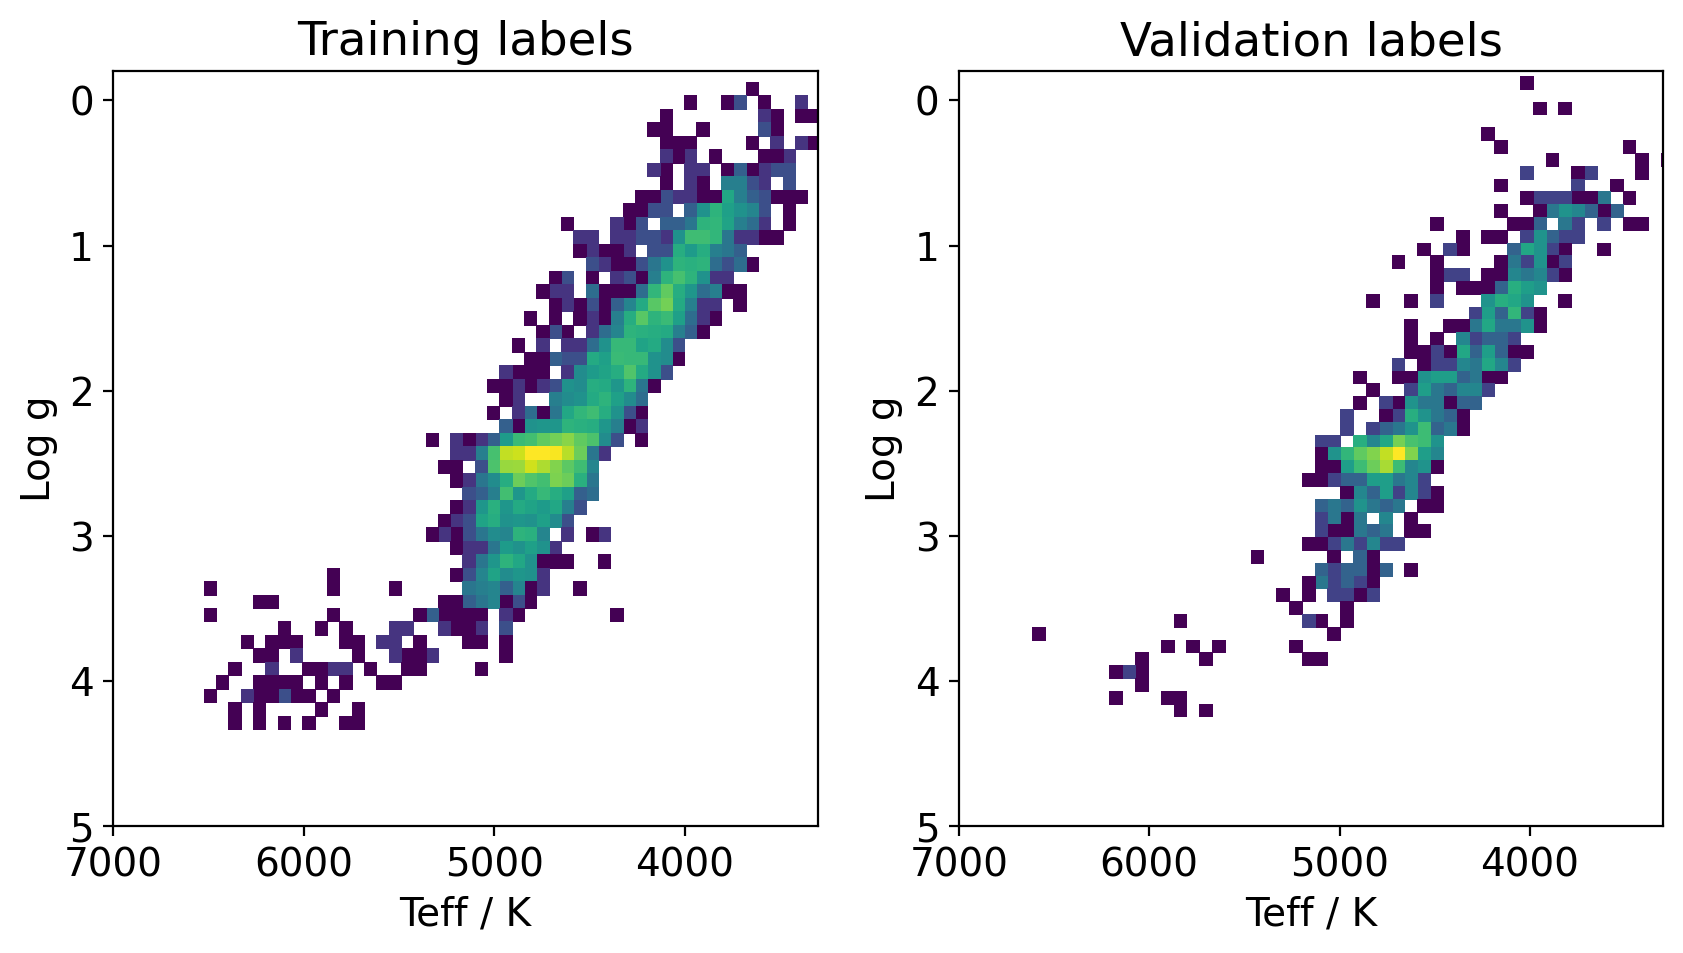

In [3]:
# Teff - Log g plot

fig, axs = plt.subplots(1,2,figsize=(10,5))


for i, ax in enumerate(axs.ravel()):

    
    if i==0:
        ax.hist2d(
        data_tr['labels'][:,0], data_tr['labels'][:,1],
        bins=50, norm=LogNorm());
        ax.set_title("Training labels");
    else:
        ax.hist2d(
        data_val['labels'][:,0], data_val['labels'][:,1],
        bins=50, norm=LogNorm());
        ax.set_title("Validation labels");
        
    ax.set_xlim([7000, 3300]);
    ax.set_ylim([5, -0.2]);
    ax.set_xlabel("Teff / K");
    ax.set_ylabel("Log g");


**show bp and rp coefficients**

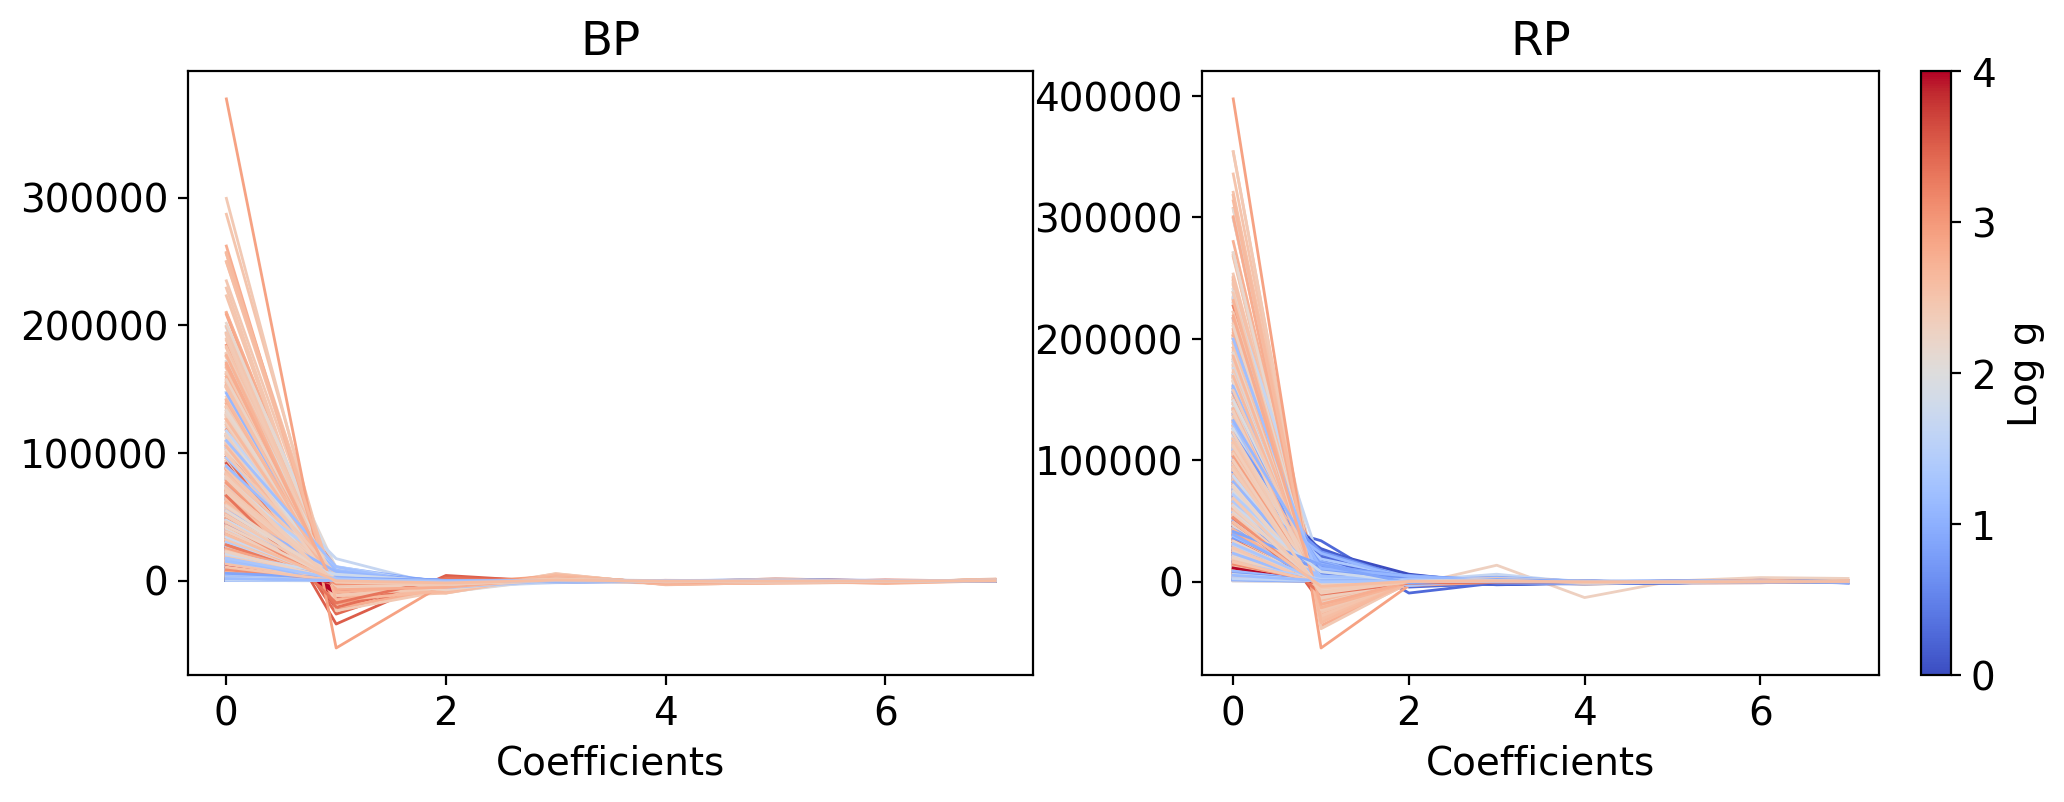

In [4]:
#first eight coefficients color coded by Logg

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
ax1, ax2 = axs.ravel()

cmap = plt.get_cmap('coolwarm')
norm = Normalize(vmin=0,vmax=4)
colors_train_logg = [cmap(norm(_)) for _ in data_tr['labels'][:,1]]

for i,idx in enumerate(range(len(data_tr['labels']))):
    
    xx = np.arange(8)
    ax1.plot(
        xx, data_tr['bp_coef'][idx,:8],lw=1,
        c=colors_train_logg[i]
    )
    ax2.plot(
        xx, data_tr['rp_coef'][idx,:8],lw=1,
        c=colors_train_logg[i]
    )
    
ax1.set_title("BP");
ax2.set_title("RP");

for ax in axs.ravel():
    ax.set_xlabel("index");
    ax.set_xlabel("Coefficients");
    
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
clb = plt.colorbar(sm, label="Log g")


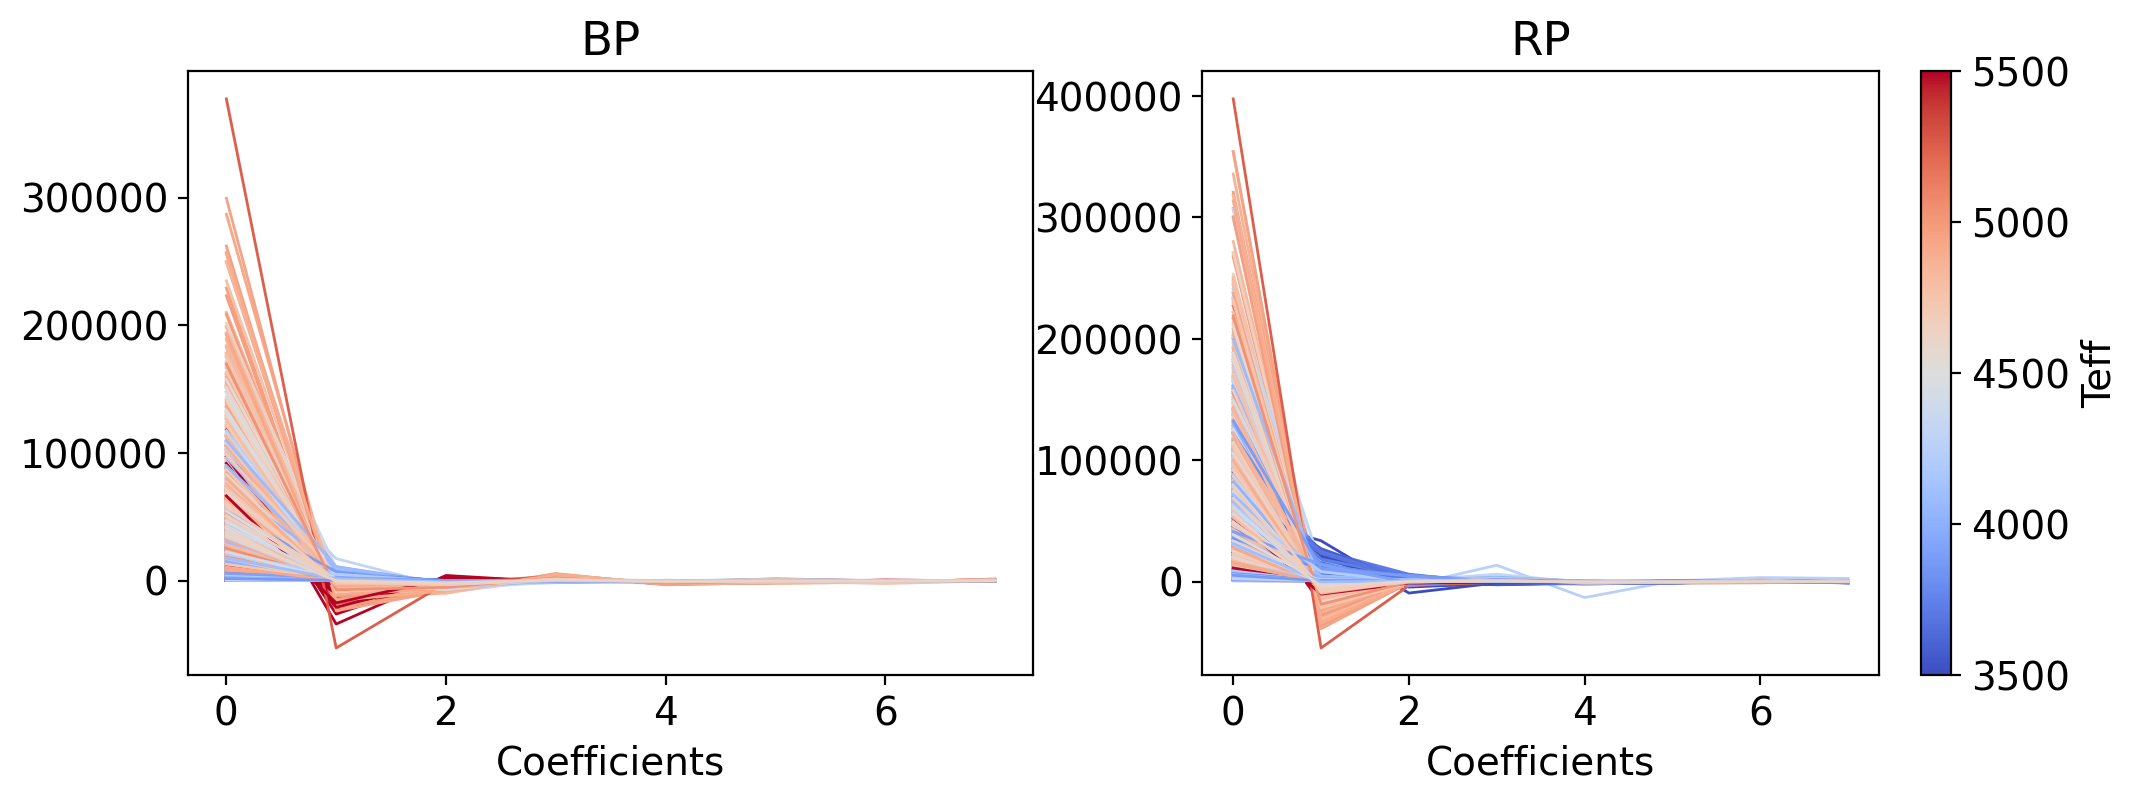

In [5]:
#first eight coefficients color coded by Teff

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
ax1, ax2 = axs.ravel()

cmap = plt.get_cmap('coolwarm')
norm = Normalize(vmin=3500, vmax=5500)
colors_train_teff = [cmap(norm(_)) for _ in data_tr['labels'][:,0]]

for i,idx in enumerate(range(len(data_tr['labels']))):
    
    xx = np.arange(8)
    ax1.plot(
        xx, data_tr['bp_coef'][idx,:8],lw=1,
        c=colors_train_teff[i]
    )
    ax2.plot(
        xx, data_tr['rp_coef'][idx,:8],lw=1,
        c=colors_train_teff[i]
    )
    
ax1.set_title("BP");
ax2.set_title("RP");

for ax in axs.ravel():
    ax.set_xlabel("index");
    ax.set_xlabel("Coefficients");
    
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
clb = plt.colorbar(sm, label="Teff")

In [6]:
print("Keys of training set and validation set are:")
print(data_tr.keys(), "\n", data_val.keys())

print("array shape of training set and validation set are:")
print([data_tr[_].shape for _ in data_tr.keys()], "\n", [data_val[_].shape for _ in data_val.keys()])

#bp_tr, rp_tr = data_tr['bp_coef'], data_tr['rp_coef']
#teff_tr = data_tr['labels'][:,0]

bp_tr_mod= bp_tr/data_tr['rp_coef'][0]
rp_tr_mod= rp_tr/data_tr['rp_coef'][0]

bp_val_mod= bp_val/data_val['rp_coef'][0]
rp_val_mod= rp_val/data_val['rp_coef'][0]

x_train = np.column_stack((bp_tr_mod, rp_tr_mod))
y_train = teff_tr
print("x_train shape", x_train.shape, "y_train shape", y_train.shape)

x_test = np.column_stack((bp_val_mod, rp_val_mod))
y_test = teff_val

print("x shape", x_test.shape, "y shape", y_test.shape)


Keys of training set and validation set are:
dict_keys(['bp_coef', 'rp_coef', 'labels']) 
 dict_keys(['bp_coef', 'rp_coef', 'labels'])
array shape of training set and validation set are:
[(4000, 55), (4000, 55), (4000, 2)] 
 [(1000, 55), (1000, 55), (1000, 2)]
x_train shape (4000, 110) y_train shape (4000,)
x shape (1000, 110) y shape (1000,)


In [9]:
# Create linear regression object and Train the model using the training sets
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(x_train, y_train)

r_sq_lr = model.score(x_train, y_train)

print(f"coefficient of determination for training: {r_sq_lr}")
print(f"intercept: {model.intercept_}")


# Make predictions using the testing set
y_pred_lr = model.predict(x_test)

# The coefficients
#print("Coefficients: \n", model.coef_)

# The mean squared error
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr_after = r2_score(y_test, y_pred)
print("Mean squared error:", mse_lr)
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination:", r2_lr_after)


coefficient of determination for training: 0.5728659278099214
intercept: 4429.437919622484
Mean squared error: 200876605.9010199
Coefficient of determination: -1107.9865124022385


Text(0.5, 1.0, 'Linear Regression')

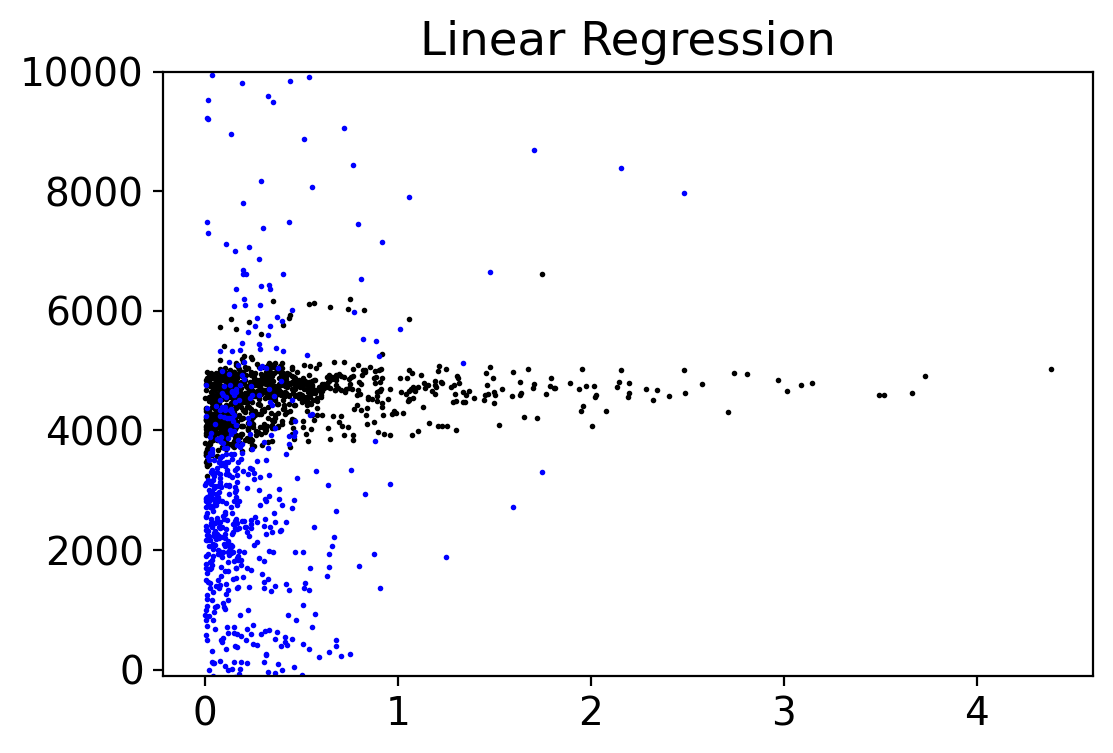

In [51]:
# Plot outputs

#plt.scatter(diabetes_X_test, diabetes_y_test, color="black")
plt.scatter(x_test[:,0], y_test, s=1, color="black")
#plt.plot(diabetes_X_test, diabetes_y_pred, color="blue", linewidth=3)
plt.scatter(x_test[:,0], y_pred_lr, color="blue", s=1)
plt.ylim(-100, 10000)
plt.title("Linear Regression")

0.008925131700664168 10.719695460803507


Text(0.5, 1.0, 'Not converged')

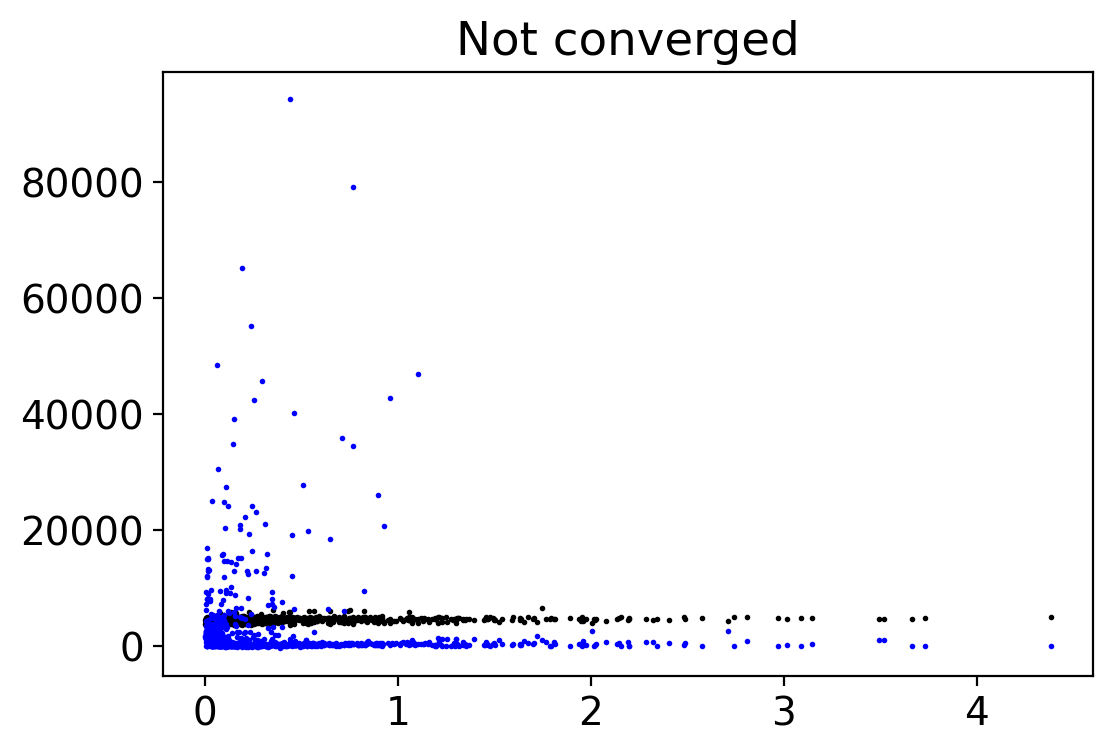

In [74]:
#Multi-layer Perceptron regressor- is a Neural Network
from sklearn.neural_network import MLPRegressor

print(x_train.mean(), x_train.std())

#mlp = MLPClassifier().fit(x_train, y_train)
mlp = MLPRegressor(solver='lbfgs',alpha=0.001,hidden_layer_sizes=(5,2), random_state=1, max_iter=100000).fit(x_train, y_train)

plt.scatter(x_test[:,0], y_test, color="black", s=1)
plt.scatter(x_test[:,0], y_pred_mlp, color="blue", s=1)
plt.title("Not converged")

In [75]:
print("MLP NEURAL NETWORK")
print("coefficient of determination for training:", mlp.score(x_train, y_train))
#make predictions using testing set
y_pred_mlp = mlp.predict(x_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_mlp))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred_mlp))


print("LINEAR REGRESSION: ")
print(f"coefficient of determination for training: {r_sq_lr}")
print("Mean squared error:", mse_lr)
print("Coefficient of determination:", r2_lr_after)


MLP NEURAL NETWORK
coefficient of determination for training: 0.6755237844558718
Mean squared error: 13942055.27
Coefficient of determination: -75.97
LINEAR REGRESSION: 
coefficient of determination for training: 0.5728659278099214
Mean squared error: 200876605.9010199
Coefficient of determination: -1107.9865124022385


**Despite not completely converging, the MLP regression is better than the linear regression.**

I tried some variants on the MLP regressor with some scaling to make it converge, but I am sticking with the orginal for my answer.

In [52]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(x_train)

x_scaled = scaler.transform(x_train)
print(x_scaled.mean(), x_scaled.std())
mlp = MLPRegressor(solver='lbfgs',alpha=0.0001,hidden_layer_sizes=(3,), random_state=1, max_iter=50000).fit(x_scaled, y_train)
print("done!")

1.9669114821722773e-17 1.0000000000000002
done!


coefficient of determination for training: 0.797917001991338
Mean squared error: 528823387.46
Coefficient of determination: -2918.49


Text(0.5, 1.0, 'Scaled')

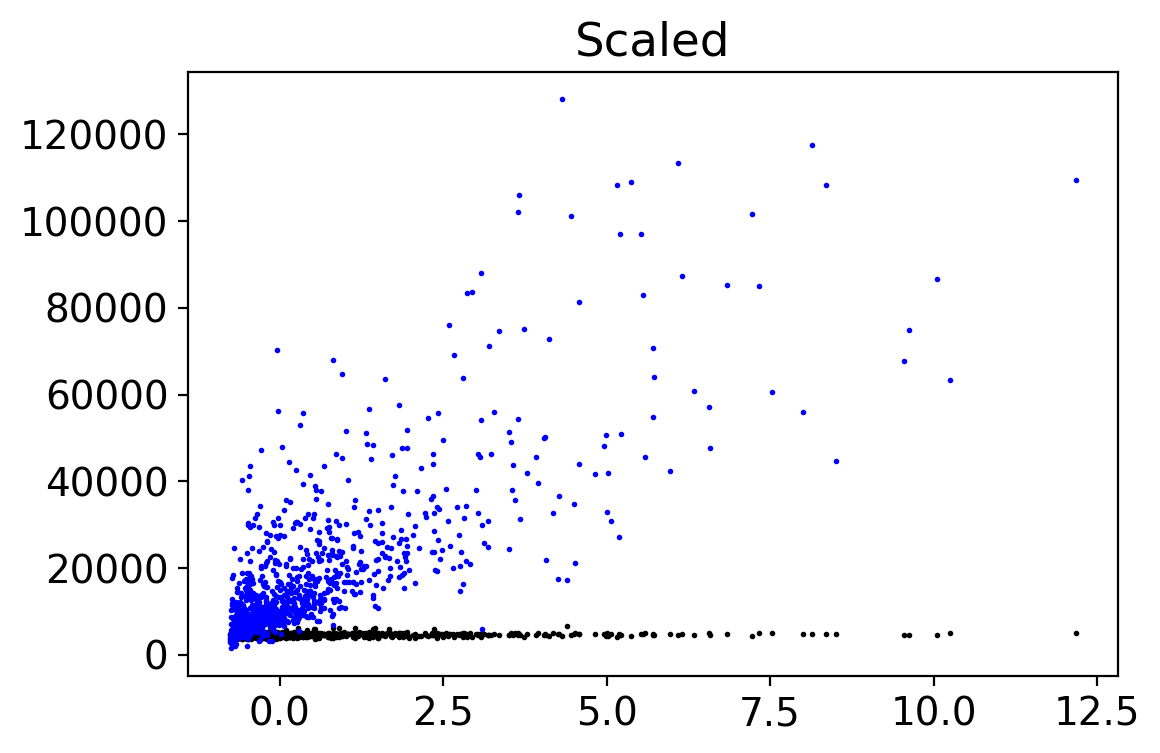

In [53]:
print("coefficient of determination for training:", mlp.score(x_scaled, y_train))
x_test_scaled = scaler.transform(x_test)

#make predictions using testing set
y_pred_mlp = mlp.predict(x_test_scaled)
#print(mlp.predict_proba(x_test[:1]))

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_mlp))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred_mlp))

# Plot outputs

plt.scatter(x_test_scaled[:,0], y_test, color="black", s=1)
plt.scatter(x_test_scaled[:,0], y_pred_mlp, color="blue", s=1)
plt.title("Scaled")

In [59]:
min_max_scaler = preprocessing.MinMaxScaler()
x_train_minmax = min_max_scaler.fit_transform(x_train)
print(x_train_minmax)
mlp = MLPRegressor(solver='lbfgs',alpha=0.001,hidden_layer_sizes=(10,), random_state=1, max_iter=5000).fit(x_train_minmax, y_train)
print("doneee")

[[0.16514855 0.19239548 0.47635873 ... 0.51924318 0.39980281 0.47090978]
 [0.09526672 0.16725218 0.5833915  ... 0.50478448 0.4235444  0.39459216]
 [0.0203506  0.2221969  0.68234033 ... 0.51410333 0.3882746  0.43378184]
 ...
 [0.13411527 0.24544977 0.52715618 ... 0.56017145 0.40795059 0.44746679]
 [0.04634168 0.22371826 0.63492135 ... 0.53453661 0.41301549 0.48268402]
 [0.09560655 0.24774364 0.57874825 ... 0.51191634 0.39769568 0.47584069]]
doneee


coefficient of determination for training: 0.5728566925383347
Mean squared error: 8675042.91
Coefficient of determination: -46.89


Text(0.5, 1.0, 'Min Max')

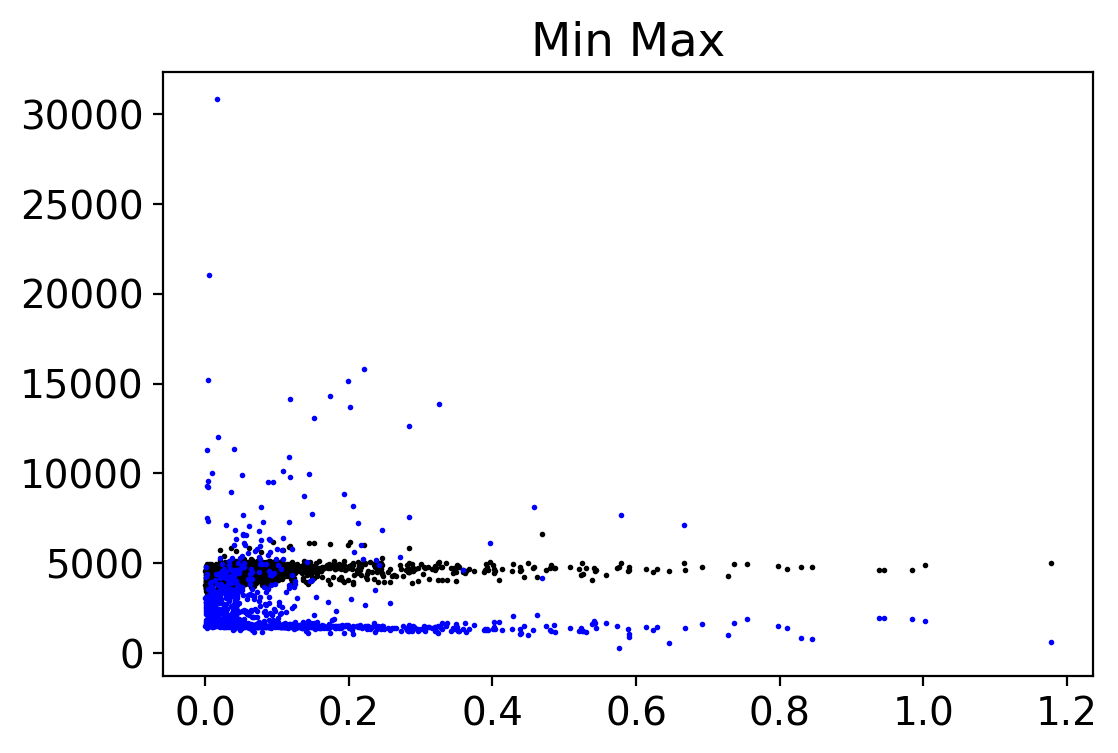

In [60]:
print("coefficient of determination for training:", mlp.score(x_train_minmax, y_train))
x_test_minmax = min_max_scaler.transform(x_test)

#make predictions using testing set
y_pred_mlp = mlp.predict(x_test_minmax)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_mlp))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred_mlp))

# Plot outputs

plt.scatter(x_test_minmax[:,0], y_test, color="black", s=1)
plt.scatter(x_test_minmax[:,0], y_pred_mlp, color="blue", s=1)
plt.title("Min Max")